# Step 1 - Import data and EDA

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split

import statsmodels.api as sm
import statsmodels.tools

df = pd.read_csv('BMW_Total_Data.csv', encoding = 'utf-8', encoding_errors='ignore')
df.head()

In [ ]:
### Price appeared as an object so removed "£" and "," then converted it into an integer

df['price'] = df['price'].str.replace('£','')
df['price'] = df['price'].str.replace(",",'')
df['price'] = df['price'].astype('int')

df

In [ ]:
### Engine L is removed and a column engine float is created to treat engine as a numeric

df['engine'] = df['engine'].str.replace('L','')
df['engine'] = df['engine'].astype('float')

In [ ]:
### Remove rows with minimal null values

df.dropna(subset=['transmission','fuel','mileage','engine'], inplace=True) 

In [ ]:
### Year and registration together form an object, now values are int

corrected_year = df['year'].str[:4]
df['corrected_year'] = corrected_year


In [ ]:
### Lots of nulls in BHP, owners, ULEZ and year

# df.isnull().sum()

In [ ]:
### We create mileage bins to make mileages more manageable

mileage_bucket = [0, 25000, 50000, 75000, 100000, 125000, 150000, 175000, 200000,225000, 250000, 275000, 300000, 1000000 ] # we define the price boundaries as a list of values
mileage_bucket_name = ['0 - 25k', '25k - 50k', '50k - 75k', '75k - 100k', '100k - 125k', '125k - 150k', '150k - 175k', '175k - 200k', '200k - 225k', '225k - 250k', '250k - 275k', '275k - 300k', '300k plus'] # we define the category names


## We pass on our lists as the 'bins' and 'labels' arguments. At the end, we make the new column's type 'category'
df['mileage_buckets'] = pd.cut(df['mileage'], #new col in dataframe, just write it as if its already there
                            bins = mileage_bucket, #bin var name
                            labels= mileage_bucket_name, #cat var name
                            include_lowest = True, #indljuce the lowest vals and amake cat: astype('category')
                            )

In [ ]:
df.columns

In [ ]:
### Only 500 nulls in years so we drop to create a corrected year
### We can now use

df.dropna(subset = ['corrected_year'], inplace=True)
df.isnull().sum()

df['corrected_year'] = df['corrected_year'].astype('int')

df['age'] = 2022 - df['corrected_year']

df.columns

In [ ]:
### Cars 2015 and over are all assumed ULEZ according to government laws
### Function made to clean up based on assumption

df_carbible_ulez = df[['transmission','fuel','body','ULEZ','engine','corrected_year','Model']].dropna(subset=['ULEZ','corrected_year'])

df_carbible_ulez.drop_duplicates(keep = 'last', inplace= True)

df_carbible_ulez['corrected_year'] = df_carbible_ulez['corrected_year'].astype(int)

def carbible(x):
    x = pd.merge(x,
                 df_carbible_ulez,
                 on =['transmission','fuel','body','engine','corrected_year','Model'],
                 how ='left',
                 )
    x['ULEZ_y'] = np.where(x['corrected_year'] > 2014,'ULEZ',x['ULEZ_y'])
    return x

def fillulez(x):
    x['ULEZ_y'] = x.ULEZ_y.fillna('NOT ULEZ')
    return x

def removeulezx(x):
    x.drop(columns= 'ULEZ_x', inplace= True)
    x.rename(columns = {'ULEZ_y' : 'ULEZ'}, inplace=True)
    return x

def clean_ulez(x):
    x = carbible(x)
    x = fillulez(x)
    x = removeulezx(x)
    return x

df_clean = clean_ulez(df)


In [ ]:
df_clean

,name,link,price,mileage,BHP,transmission,fuel,owners,body,engine,year,Model,Make,corrected_year,mileage_buckets,age,ULEZ
0,BMW 1 Series,https://www.autotrader.co.uk/dealers/surrey/wo...,1895,128000.0,NaN,Manual,Petrol,NaN,Hatchback,1.6,2005 (05 reg),1 Series,BMW,2005,125k - 150k,17,ULEZ
1,BMW 1 Series,https://www.autotrader.co.uk/dealers/warwicksh...,1250,149567.0,NaN,Manual,Diesel,NaN,Hatchback,2.0,2005 (55 reg),1 Series,BMW,2005,125k - 150k,17,NOT ULEZ
2,BMW 1 SERIES,https://www.autotrader.co.uk/dealers/bedfordsh...,1799,124689.0,NaN,Manual,Petrol,NaN,Hatchback,2.0,2005 (05 reg),1 Series,BMW,2005,100k - 125k,17,ULEZ
3,BMW 1 Series,https://www.autotrader.co.uk/dealers/kent/sitt...,2500,111000.0,NaN,Manual,Petrol,11.0,Hatchback,1.6,2005 (55 reg),1 Series,BMW,2005,100k - 125k,17,ULEZ
4,BMW 1 Series,https://www.autotrader.co.uk/dealers/middlesex...,2999,92000.0,NaN,Automatic,Petrol,NaN,Hatchback,2.0,2005 (55 reg),1 Series,BMW,2005,75k - 100k,17,ULEZ
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26019,BMW X5,https://www.autotrader.co.uk/dealers/berkshire...,59980,35694.0,NaN,Automatic,Diesel,NaN,SUV,3.0,2021 (21 reg),x5,BMW,2021,25k - 50k,1,ULEZ
26020,BMW X5 Series,https://www.autotrader.co.uk/dealers/cheshire/...,67999,20831.0,NaN,Automatic,Petrol Plug-in Hybrid,NaN,SUV,3.0,2021 (71 reg),x5,BMW,2021,0 - 25k,1,ULEZ
26021,BMW X5 Series,https://www.autotrader.co.uk/dealers/kincardin...,66150,5500.0,NaN,Automatic,Diesel Hybrid,NaN,SUV,3.0,2021 (71 reg),x5,BMW,2021,0 - 25k,1,ULEZ
26022,BMW X5 Series,https://www.autotrader.co.uk/dealers/inverness...,57998,22444.0,NaN,Automatic,Diesel Hybrid,NaN,SUV,3.0,2021 (21 reg),x5,BMW,2021,0 - 25k,1,ULEZ


In [ ]:
### ULEZ can now be transformed into boolean but BHP has too many nulls so we drop this column

In [ ]:
### BHP has far too many nulls to work with and link has no relevance to the price of the data so we drop these columns
### Names were split into models to be groupable and more consistency so do not need names
### Drop year as we now have corrected_year

df_clean.drop(columns = ['BHP', 'name', 'link', 'Make', 'year','corrected_year'], inplace = True)
df_clean.columns

Index(['price', 'mileage', 'transmission', 'fuel', 'owners', 'body', 'engine',
       'Model', 'mileage_buckets', 'age', 'ULEZ'],
      dtype='object')

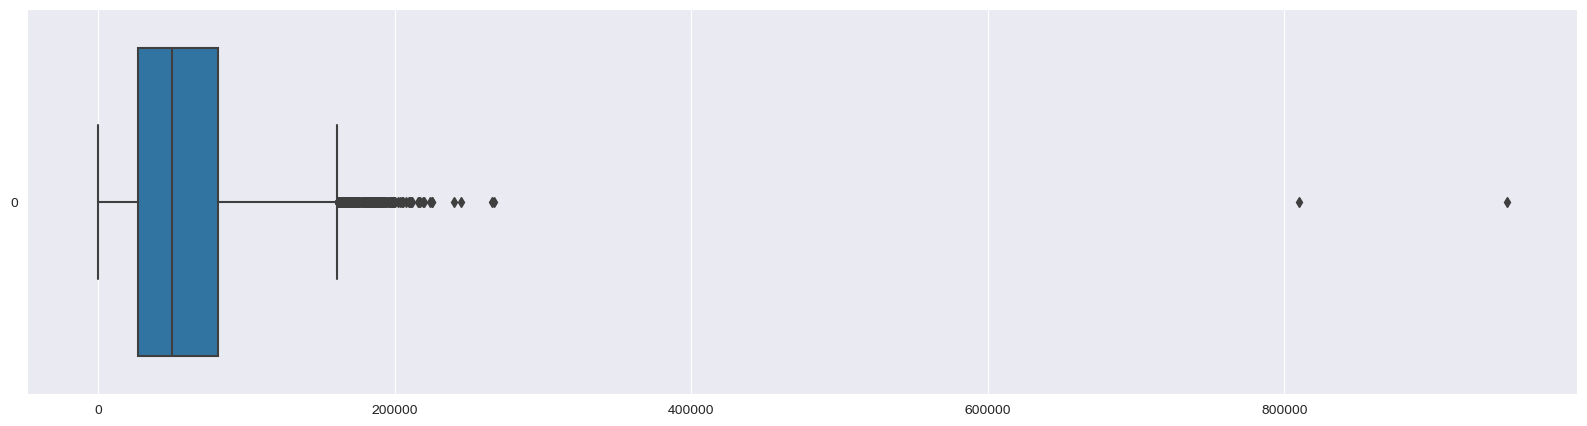

In [ ]:
plt.figure(figsize = (20, 5))
sns.boxplot(data = df_clean['mileage'],
            orient = 'h')
plt.show()

In [ ]:
df_clean = df_clean.drop(df_clean[df_clean.mileage> 240000].index)
df_clean = df_clean.drop(df_clean[df_clean.price> 75000].index)

In [ ]:
# plt.figure(figsize = (10, 10))
# sns.heatmap(df_clean.corr(), annot = True)

# plt.show()

### Price and year
### Price and mileage
### Multicollinearity in mileage and year (-0.74)
### Most data are categorical so will have to engineer into numerics in feature engineering ###

In [ ]:
# df_clean['corrected_year'].value_counts()

In [ ]:
### Price and mileage
### 

# sns.pairplot(df_clean[['price', 'mileage']],
#              height = 5)

# plt.show()

In [ ]:
### High correlation so might wanna include this

# plt.figure( figsize = (20, 10))

# sns.barplot(x = 'corrected_year', y = 'price',
#             data = df_clean)

# plt.show()

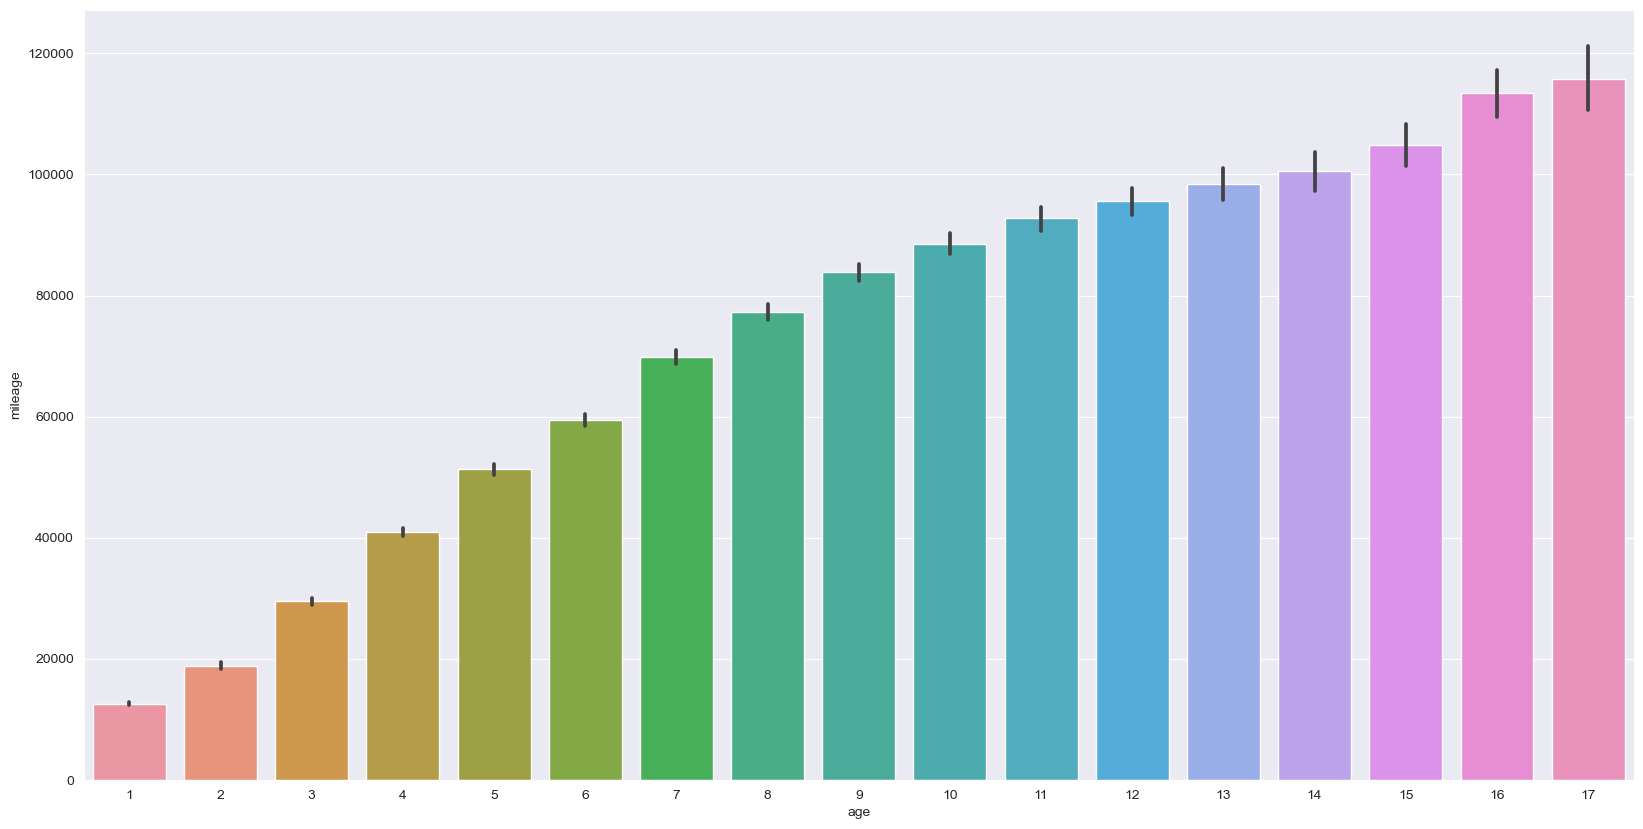

In [ ]:
### Very high multicollinearity, must alter mileage

plt.figure(figsize= (20,10))

sns.barplot(x = 'age',
            y = 'mileage',
            data= df_clean,
            )

plt.show()

# Step 2 - Train Test Split

In [ ]:
# First we make a list of our base feature_cols.
# This is everything but we're removing price - since that's our target!

feature_cols = list(df_clean.columns)
feature_cols.remove('price')

print(feature_cols)

['mileage', 'transmission', 'fuel', 'owners', 'body', 'engine', 'Model', 'mileage_buckets', 'age', 'ULEZ']


In [ ]:
# Create X, and y.
# target does change, thats what we r trying to dunerstand why it changes

X = df_clean[feature_cols]
y = df_clean['price']

print(X)
print(y) #just a series of the target

        mileage transmission                   fuel  owners       body  \
0      128000.0       Manual                 Petrol     NaN  Hatchback   
1      149567.0       Manual                 Diesel     NaN  Hatchback   
2      124689.0       Manual                 Petrol     NaN  Hatchback   
3      111000.0       Manual                 Petrol    11.0  Hatchback   
4       92000.0    Automatic                 Petrol     NaN  Hatchback   
...         ...          ...                    ...     ...        ...   
26019   35694.0    Automatic                 Diesel     NaN        SUV   
26020   20831.0    Automatic  Petrol Plug-in Hybrid     NaN        SUV   
26021    5500.0    Automatic          Diesel Hybrid     NaN        SUV   
26022   22444.0    Automatic          Diesel Hybrid     NaN        SUV   
26023   10153.0    Automatic          Diesel Hybrid     NaN        SUV   

       engine     Model mileage_buckets  age      ULEZ  
0         1.6  1 Series     125k - 150k   17      ULEZ

In [ ]:
## The train_test_split function returns 4 items.
## We have to specify 4 names in their specific order to receive each item:
## 1. X train set, 2. X test set, 3. y train set, 4. y test set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# print(X_train) #21k rows
# print(X_test) #5k rows
# #%%
# ##make sure split worked correctly:
# print(len(X_train) == len(y_train))
# print(len(X_test) == len(y_test))


In [ ]:
# X_train.isnull().sum()

# Step 3 - Feature Engineering

In [ ]:
### One hot encode categorical values
### We will log mileage
### Mean owners - don't want to get rid of owner nulls
##  -----> Group by mileage buckets and years

In [ ]:
### MEAN FUNCTION ON OWNERS

def mean_owners(dataf, y):
  ''' X_train and y_train must be merged first (by index) so that dimensions remain consistent when removing rows '''
  X_y = pd.merge(dataf, y,
              left_index = True,
              right_index = True,
              how ='left')
    

  ''' Create variables and a new dataframe in which owner nulls are adjusted to means and removed entirely '''    
  mean_owners = X_train.groupby(['mileage_buckets', 'age'])['owners'].mean()

  mean_owners = pd.DataFrame(data = mean_owners)

  joined_owners = pd.merge(X_y,
                         mean_owners,
                         on =['mileage_buckets', 'age'],
                         how ='left')
  
  joined_owners['owners_adjusted'] = joined_owners.owners_x.fillna(joined_owners.owners_y)

  joined_owners = joined_owners.drop(columns = ['owners_x','owners_y'])

  joined_owners.dropna(subset=['owners_adjusted'] , inplace=True)


  ''' Finally, recreate X_train(dataf) and y_train (y) by assigning them to relevant columns '''
  y_train = joined_owners['price']

  dataf = joined_owners.drop(columns = ['price'])

  return dataf, y_train

In [ ]:
### OHE CATEGORICS FUNCTION

def ohe(dataf):
  dataf = pd.get_dummies(dataf, columns = ['body','transmission','fuel','Model','ULEZ',], drop_first=True)
  
  return dataf

In [ ]:
### TRANSFORMATIONS ON FEATURES FUNCTION

def transform(dataf):
  dataf['log_mileage'] = np.log(dataf['mileage'])
  dataf['log_age'] = np.log(dataf['age'])
  return dataf

In [ ]:
### Feature engineering function

def feature_engineer(dataf, y):
  dataf, y_train = mean_owners(dataf, y)
  dataf = ohe(dataf)
  dataf = transform(dataf)
  dataf = sm.add_constant(dataf)
  return dataf, y_train

In [ ]:
X_train_eng, y_train = feature_engineer(X_train, y_train)

In [ ]:
y_train.isnull().sum()

0

In [ ]:
### We can view correlations now with categorics into numericals and nulls dealt with!

# plt.figure(figsize = (20, 10))
# sns.heatmap(X_train_engineered.corr(), annot = True)

# plt.show()

In [ ]:
X_train_eng.columns

Index(['const', 'mileage', 'engine', 'mileage_buckets', 'age',
       'owners_adjusted', 'body_Coupe', 'body_Estate', 'body_Hatchback',
       'body_MPV', 'body_SUV', 'body_Saloon', 'transmission_Manual',
       'fuel_Diesel Hybrid', 'fuel_Petrol', 'fuel_Petrol Hybrid',
       'fuel_Petrol Plug-in Hybrid', 'Model_2 Series', 'Model_3 Series',
       'Model_4 Series', 'Model_4 Series gran coup', 'Model_5 Series',
       'Model_x1', 'Model_x3', 'Model_x5', 'ULEZ_ULEZ', 'log_mileage',
       'log_age'],
      dtype='object')

## Step 4 - Predict on the training data

In [ ]:
### Linreg

## Try experimenting with different sets of feature columns and see how they influence your model.
## What happens if you remove the constant? will get a warning

##keep in the constant

feature_cols = ['const','mileage', 'engine', 'age',
       'owners_adjusted', 'body_Coupe', 'body_Estate', 'body_Hatchback',
       'body_MPV', 'body_SUV', 'body_Saloon', 'transmission_Manual',
       'fuel_Diesel Hybrid', 'fuel_Petrol', 'fuel_Petrol Hybrid',
       'fuel_Petrol Plug-in Hybrid', 'Model_2 Series', 'Model_3 Series',
       'Model_4 Series', 'Model_4 Series gran coup', 'Model_5 Series',
       'Model_x1', 'Model_x3', 'Model_x5', 'ULEZ_ULEZ', 'log_mileage', 'log_age']

## output says theres alot of multicolineraity
lin_reg = sm.OLS(y_train, X_train_eng[feature_cols])
results = lin_reg.fit()
print(results.summary())



                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                     7081.
Date:                Thu, 27 Oct 2022   Prob (F-statistic):               0.00
Time:                        15:47:10   Log-Likelihood:            -2.0041e+05
No. Observations:               20788   AIC:                         4.009e+05
Df Residuals:                   20761   BIC:                         4.011e+05
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [ ]:
X_train_eng['y_pred'] = results.predict(X_train_eng[feature_cols])

rmse = statsmodels.tools.eval_measures.rmse(y_train, X_train_eng['y_pred'])

print(rmse) 

3721.0221702064578


In [ ]:
### Edit the feature_cols to optimise RMSE and condition and R squared

feature_cols = ['const', 'engine', 'body_Hatchback', 'body_Saloon', 'transmission_Manual', 'fuel_Petrol Hybrid',
       'fuel_Petrol Plug-in Hybrid', 'Model_2 Series',
       'Model_4 Series', 
       'Model_x1','log_age'] 

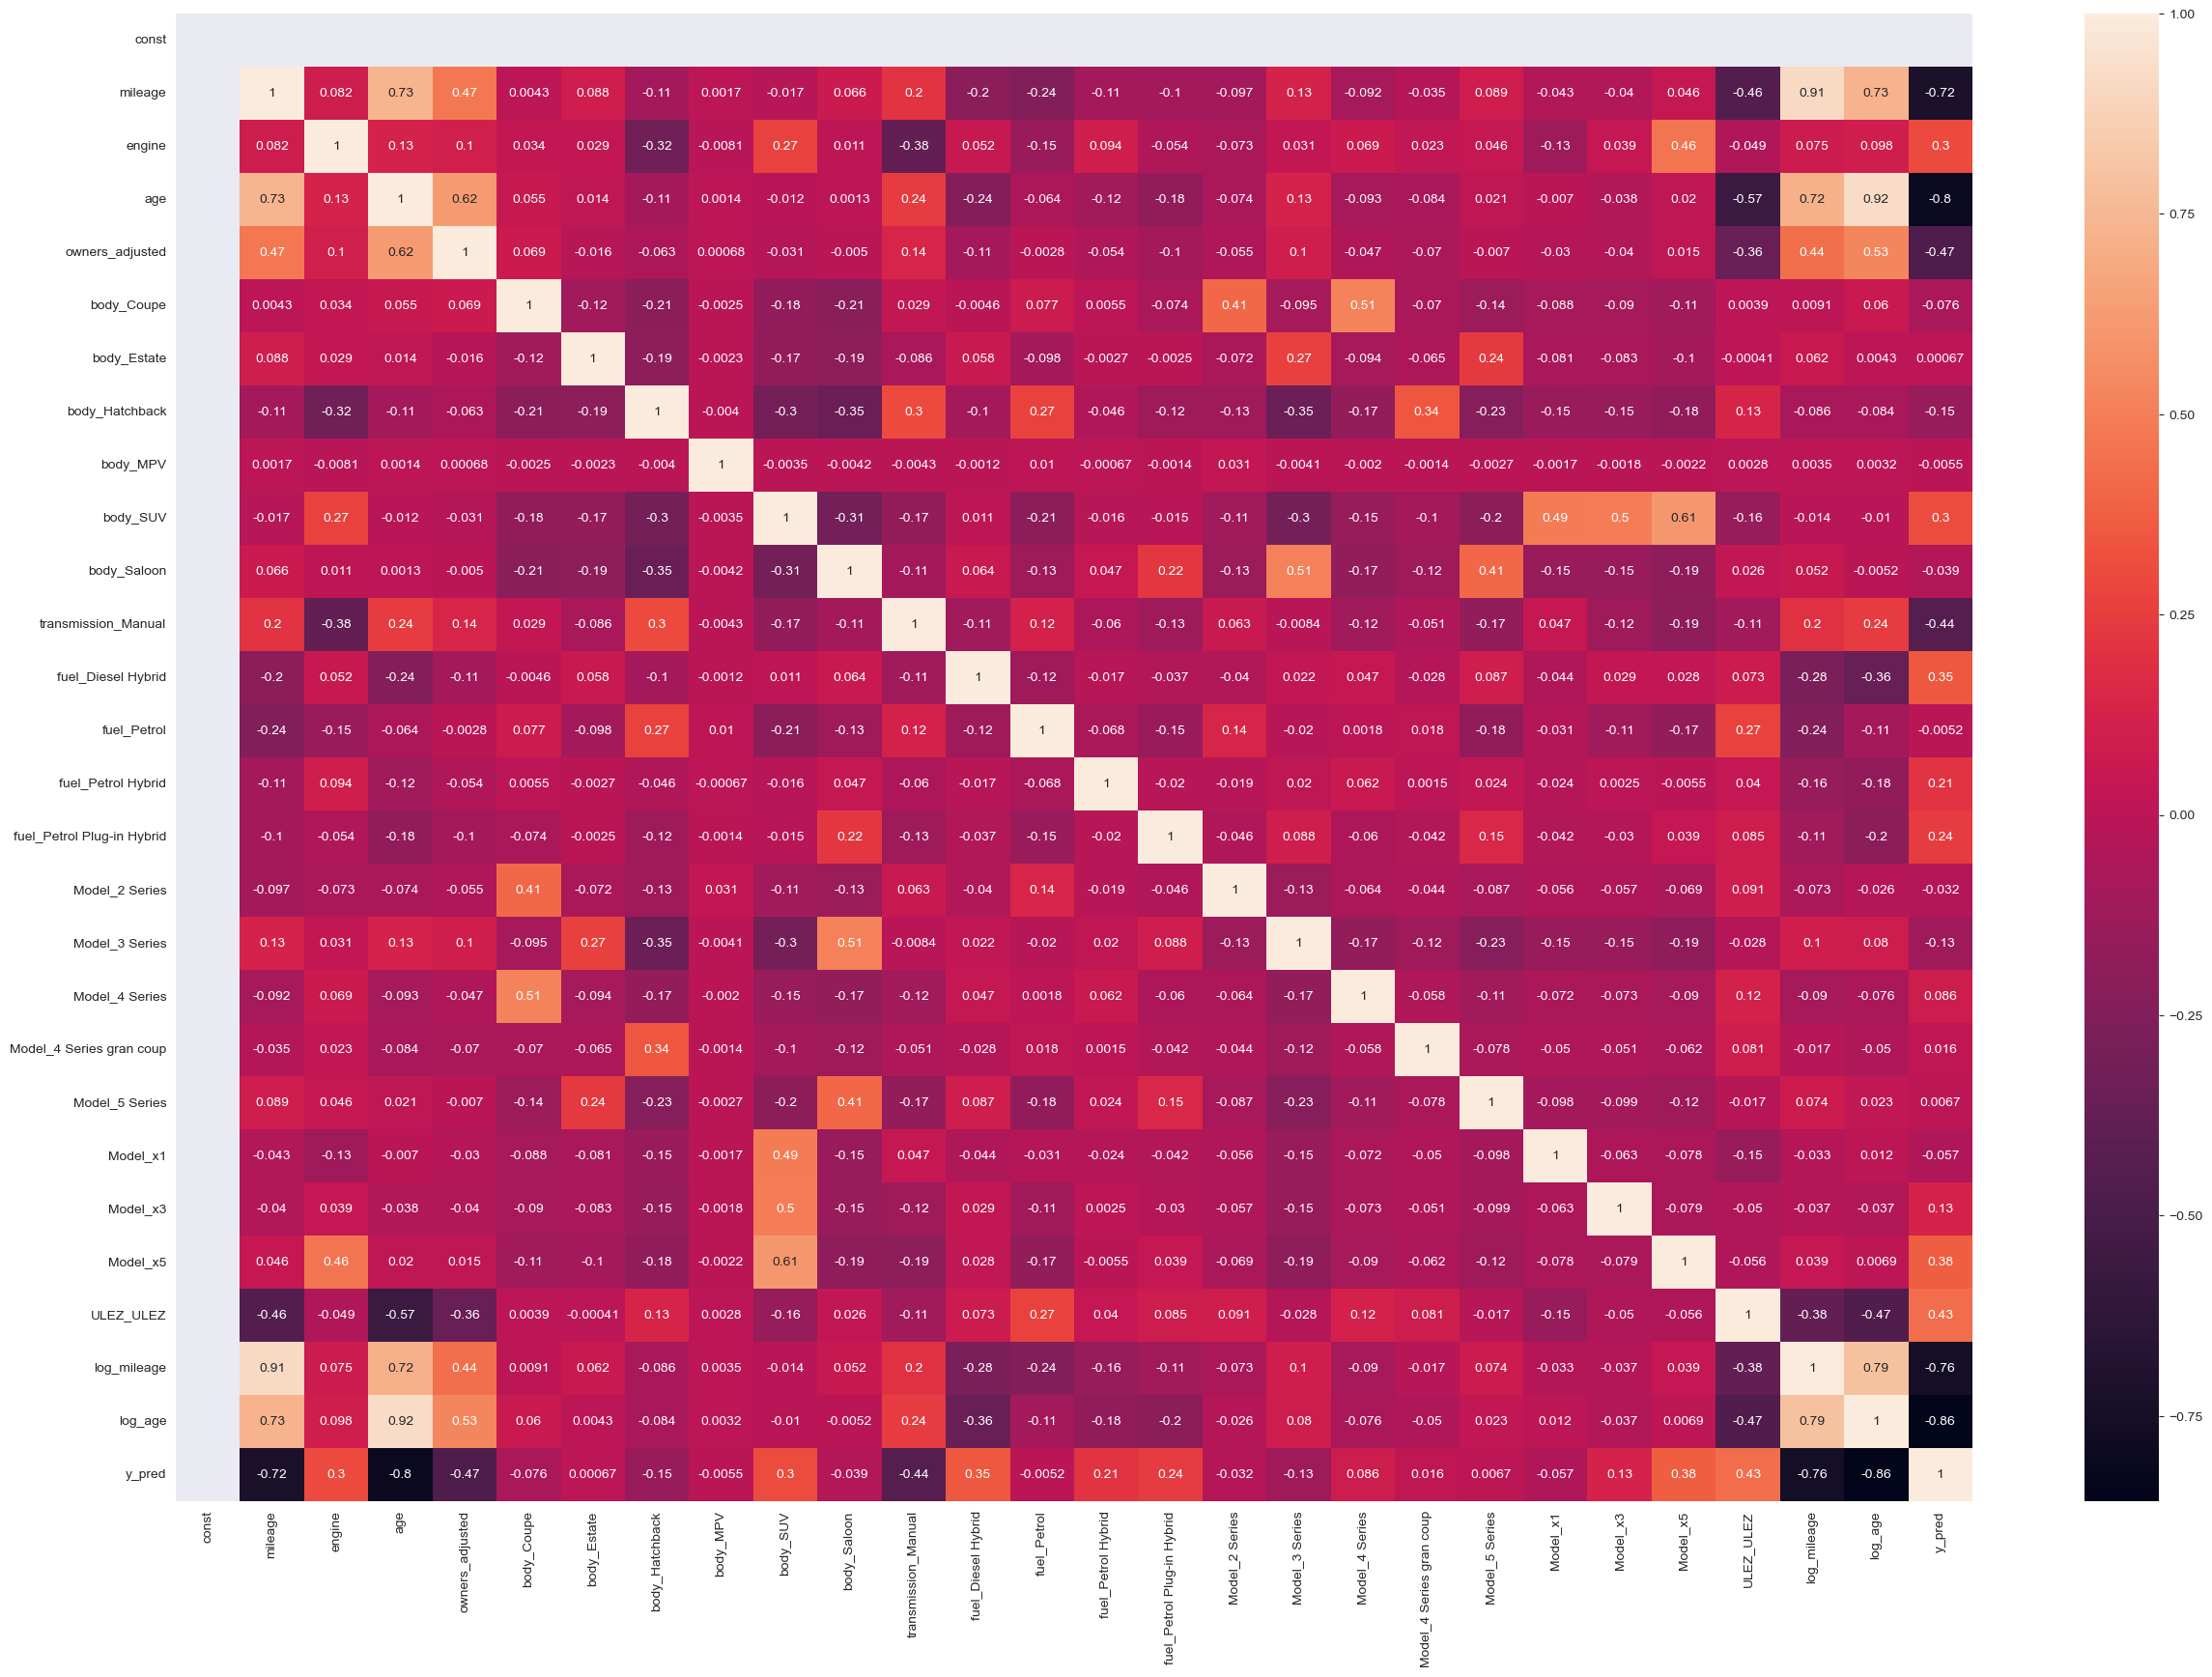

In [ ]:
plt.figure(figsize = (30, 20))
sns.heatmap(X_train_eng.corr(), annot = True)

plt.show()

In [ ]:
X_train_eng

,const,mileage,engine,mileage_buckets,age,owners_adjusted,body_Coupe,body_Estate,body_Hatchback,body_MPV,...,Model_4 Series,Model_4 Series gran coup,Model_5 Series,Model_x1,Model_x3,Model_x5,ULEZ_ULEZ,log_mileage,log_age,y_pred
0,1.0,27766.0,3.0,25k - 50k,1,2.142857,0,0,0,0,...,0,0,0,0,0,1,1,10.231568,0.000000,54265.023180
1,1.0,11000.0,2.0,0 - 25k,5,2.397436,0,0,0,0,...,0,0,0,1,0,0,1,9.305651,1.609438,22729.857277
2,1.0,132000.0,2.0,125k - 150k,9,2.000000,0,1,0,0,...,0,0,0,0,0,0,1,11.790557,2.197225,6536.953102
3,1.0,46766.0,2.0,25k - 50k,1,2.142857,0,0,0,0,...,0,0,0,0,0,0,1,10.752912,0.000000,36254.583113
4,1.0,78229.0,1.5,75k - 100k,4,2.166667,0,0,1,0,...,0,0,0,0,0,0,1,11.267396,1.386294,13427.222429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20803,1.0,16956.0,1.5,0 - 25k,4,2.258706,0,0,0,0,...,0,0,0,1,0,0,1,9.738377,1.386294,20903.180892
20804,1.0,7797.0,1.5,0 - 25k,2,2.111498,0,0,1,0,...,0,0,0,0,0,0,1,8.961494,0.693147,27700.976931
20805,1.0,42000.0,1.6,25k - 50k,10,2.620000,0,0,1,0,...,0,0,0,0,0,0,1,10.645425,2.302585,6973.481650
20806,1.0,44601.0,2.0,25k - 50k,3,2.241117,1,0,0,0,...,1,0,0,0,0,0,1,10.705512,1.098612,23977.067561


In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor # a module to evaluate the variance inflation factor (VIF)

In [ ]:
## This a piece of code from stats.stackexchange.com

## It runs the model with all of the variables. 
## If any of them have a higher VIF than 5, it drops the max. 
## Then it keeps going until none of them have a higher VIF than 5.
## This leaves us with a nice set of features with no collineraity

def calculate_vif(X, thresh = 5.0):
    variables = list(range(X.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        # this bit uses list comprehension to gather all the VIF values of the different variables
        vif = [variance_inflation_factor(X.iloc[:, variables].values, ix)
               for ix in range(X.iloc[:, variables].shape[1])]
        
        del vif[0]
        maxloc = vif.index(max(vif)) + 1 # getting the index of the highest VIF value
        if max(vif) > thresh:
            print('dropping \'' + X.iloc[:, variables].columns[maxloc] +
                  '\' at index: ' + str(maxloc))
            del variables[maxloc] # we delete the highest VIF value on condition that it's higher than the threshold
            dropped = True # if we deleted anything, we set the 'dropped' value to True to stay in the while loop

    print('Remaining variables:')
    print(X.columns[variables]) # finally, we print the variables that are still in our set
    return X.iloc[:, variables] # and return our X cut down to the remaining variables

In [ ]:
def checkVIF(X):
    vif = pd.DataFrame() ##make empty df, we add results to this
    vif['Features'] = feature_cols ##in df we r modelling, feautres used in training

    #calc vif for each feautre using function imported w statsmodels
    vif['VIF'] = [variance_inflation_factor(X[feature_cols].values, i) for i in range(X[feature_cols].shape[1])]
    vif['VIF'] = round(vif['VIF'], 2) #rounding 2 d.p
    vif = vif.sort_values(by = "VIF", ascending = False) # sort highest to lowest multinairty. what we need toget rid of
    return(vif)

In [ ]:
checkVIF(X_train_eng)

,Features,VIF
0,const,39.67
2,body_Hatchback,1.76
3,body_Saloon,1.48
1,engine,1.41
4,transmission_Manual,1.39
10,log_age,1.24
9,Model_x1,1.21
8,Model_4 Series,1.19
7,Model_2 Series,1.16
6,fuel_Petrol Plug-in Hybrid,1.13


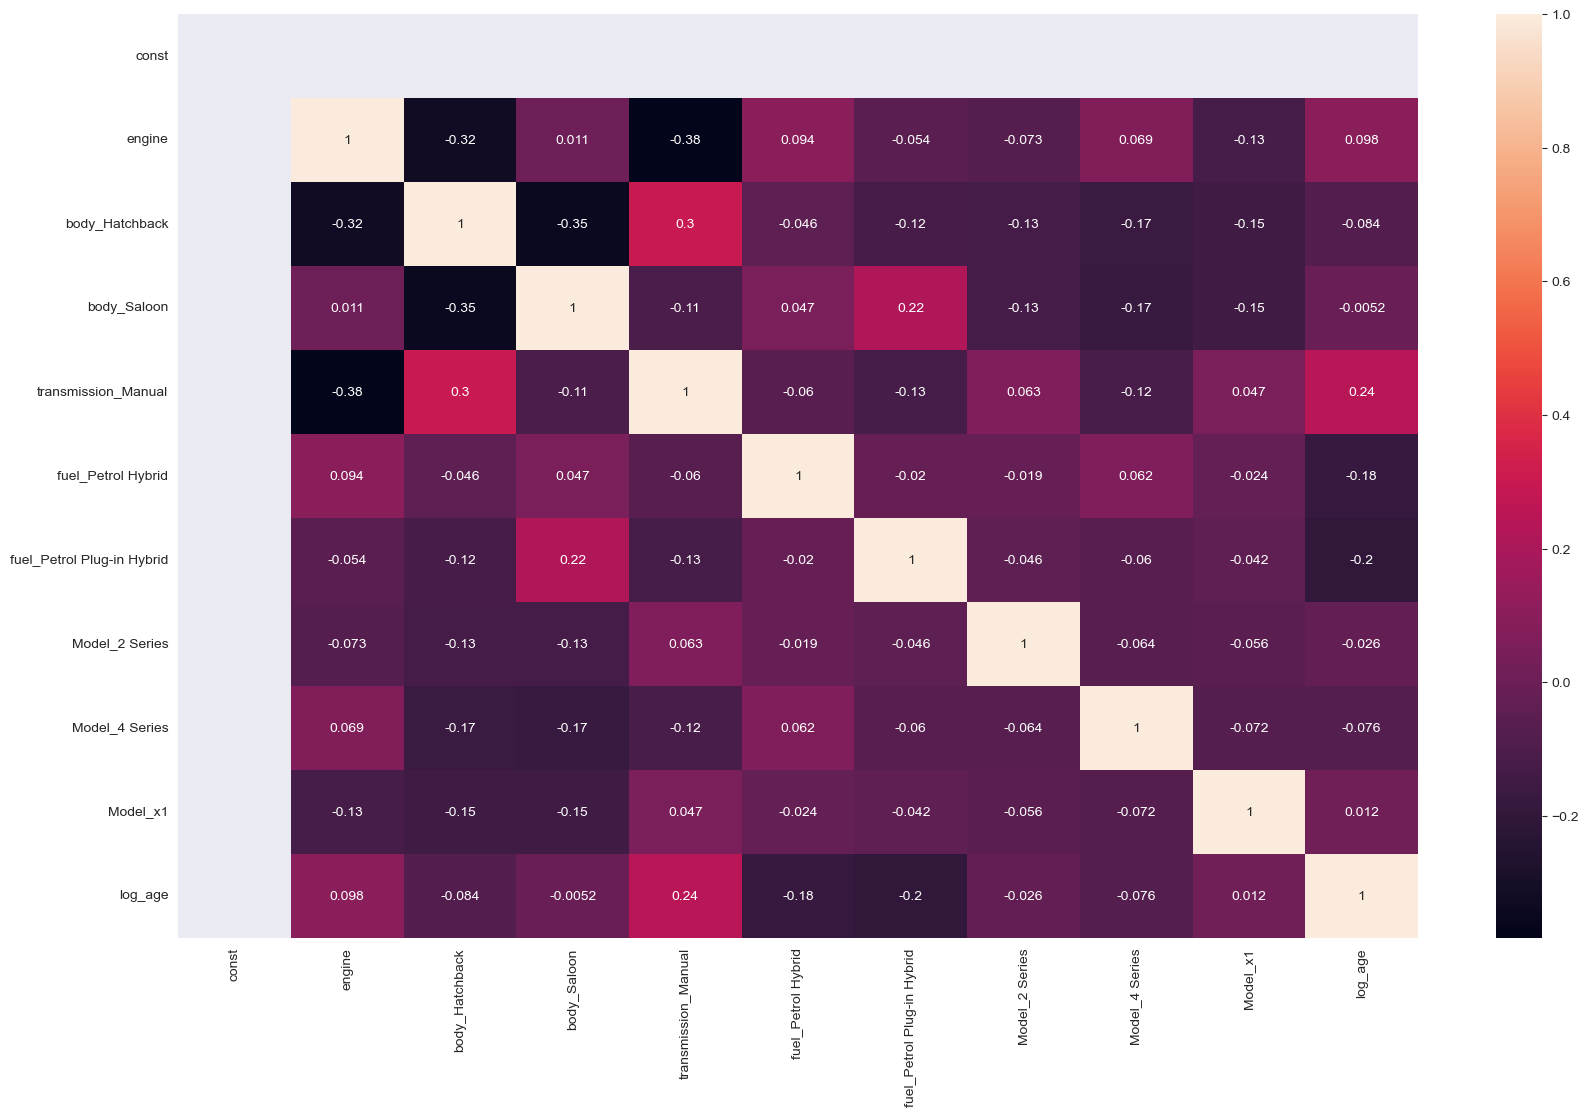

In [ ]:
plt.figure(figsize = (20, 12))
sns.heatmap(X_train_eng[feature_cols].corr(), annot = True)

plt.show()

In [ ]:
### Linreg

## Try experimenting with different sets of feature columns and see how they influence your model.
## What happens if you remove the constant? will get a warning

##keep in the constant

feature_cols = ['const', 'engine', 'body_Hatchback', 'body_Saloon', 'transmission_Manual', 'fuel_Petrol Hybrid',
                               'fuel_Petrol Plug-in Hybrid', 'Model_2 Series',
                               'Model_4 Series',
                               'Model_x1','log_age']

## output says theres alot of multicolineraity
lin_reg = sm.OLS(y_train, X_train_eng[feature_cols])
results = lin_reg.fit()
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                 1.014e+04
Date:                Thu, 27 Oct 2022   Prob (F-statistic):               0.00
Time:                        15:47:15   Log-Likelihood:            -2.0579e+05
No. Observations:               20788   AIC:                         4.116e+05
Df Residuals:                   20777   BIC:                         4.117e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [ ]:
X_train_eng['y_pred'] = results.predict(X_train_eng[feature_cols])

rmse = statsmodels.tools.eval_measures.rmse(y_train, X_train_eng['y_pred'])

print(rmse)

4820.251580971907


In [ ]:
X_test_eng, y_test = feature_engineer(X_test, y_test)
X_test_eng = X_test_eng[feature_cols]  ##select only the cols we used in x_train
#print(X_test_eng) # see if it looks like training
##we are not doing lin_reg.fit(), bcs we dont want the model to matchthe distubration of the test data! we want to make the model on the training set not the testing! do not retest. just use the equation to predict the price of the diamonds

In [ ]:

X_test_eng['y_pred'] = results.predict(X_test_eng)
rmse = statsmodels.tools.eval_measures.rmse(y_test,
                                            X_test_eng['y_pred'])  ##evulating the performance of model on test daat

print(rmse)

4644.330656998173
